<a href="https://colab.research.google.com/github/MartinPdeS/FlowCyPy/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install FlowCyPy --no-cache-dir --quiet

In [ ]:
import FlowCyPy
print(FlowCyPy.__version__)

0.15.0


In [ ]:
from FlowCyPy import FlowCytometer, ScattererCollection, Detector, GaussianBeam, FlowCell
from FlowCyPy import distribution
from FlowCyPy.population import Sphere
from FlowCyPy.signal_digitizer import SignalDigitizer
from FlowCyPy import units
from FlowCyPy import peak_locator
from FlowCyPy import classifier

import numpy
numpy.random.seed(3)

In [ ]:
source = GaussianBeam(
    numerical_aperture=0.3 * units.AU,  # Numerical aperture: 0.3
    wavelength=800 * units.nanometer,   # Laser wavelength: 800 nm
    optical_power=20 * units.milliwatt  # Optical power: 20 milliwatts
)

flow_cell = FlowCell(
    source=source,
    volume_flow=0.3 * units.microliter / units.second,        # Flow speed: 10 microliter per second
    flow_area=(20 * units.micrometer) ** 2,        # Flow area: 10 x 10 micrometers
)

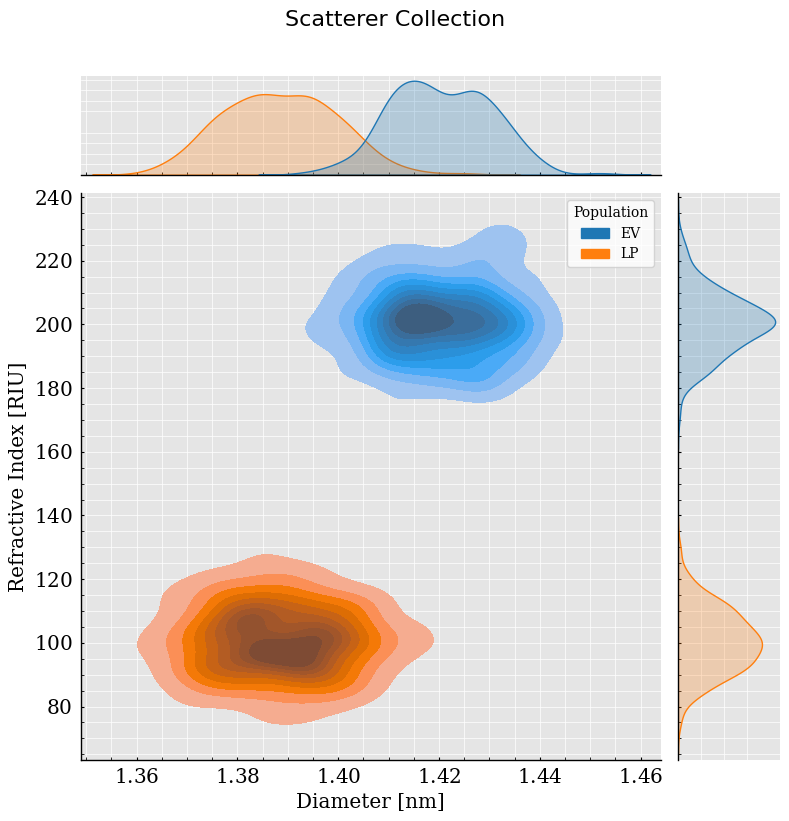

In [ ]:
dist_diameter = distribution.Normal(mean=200 * units.nanometer, std_dev=10 * units.nanometer)

dist_ri = distribution.Normal(mean=1.42 * units.RIU, std_dev=0.01 * units.RIU)

EVs = Sphere( # Name of the particle population: Extracellular Vesicles (EV)
    name='EV',
    particle_count=3e9 * units.particle / units.milliliter,
    diameter=dist_diameter,
    refractive_index=dist_ri,
)


dist_diameter = distribution.Normal(mean=100 * units.nanometer, std_dev=10 * units.nanometer)

dist_ri = distribution.Normal(mean=1.39 * units.RIU, std_dev=0.01 * units.RIU)

LPs = Sphere( # Name of the particle population: Liposomes (LP)
    name='LP',
    particle_count=10e9 * units.particle / units.milliliter,
    diameter=dist_diameter,
    refractive_index=dist_ri,
)

scatterer_collection = ScattererCollection()

scatterer_collection.add_population(EVs, LPs)

scatterer_collection.dilute(30)

scatterer_collection.plot(sampling=200)

In [ ]:
signal_digitizer = SignalDigitizer(
    bit_depth=1024,
    saturation_levels='auto',
    sampling_rate=10 * units.megahertz,        # Sampling frequency: 10 MHz
)

detector_0 = Detector(
    phi_angle=90 * units.degree,               # Detector angle: 90 degrees (Side Scatter)
    numerical_aperture=0.4 * units.AU,         # Numerical aperture of the detector
    name='side',                               # Detector name
    responsivity=1 * units.ampere / units.watt,   # Responsitivity of the detector (light to signal conversion efficiency)
)

detector_1 = Detector(
    phi_angle=0 * units.degree,               # Detector angle: 90 degrees (Sid e Scatter)
    numerical_aperture=0.4 * units.AU,        # Numerical aperture of the detector
    name='forward',             # Detector name
    responsivity=1 * units.ampere / units.watt,   # Responsitivity of the detector (light to signal conversion efficiency)
)


cytometer = FlowCytometer(
    signal_digitizer=signal_digitizer,
    scatterer_collection=scatterer_collection,
    flow_cell=flow_cell,                # Particle size distribution
    detectors=[detector_0, detector_1]  # List of detectors used in the simulation
)

# Run the flow cytometry simulation
acquisition = cytometer.prepare_acquisition(run_time=15.0 * units.millisecond)
acquisition = cytometer.get_acquisition()

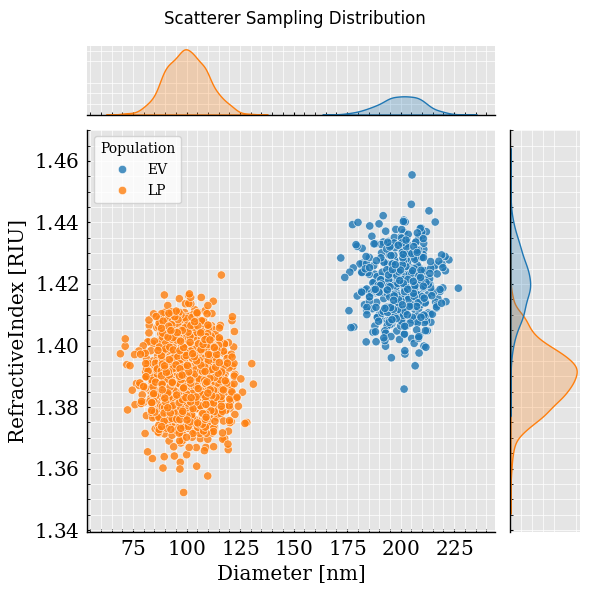

In [ ]:
acquisition.scatterer.plot(
    x='Diameter',
    y='RefractiveIndex'
)

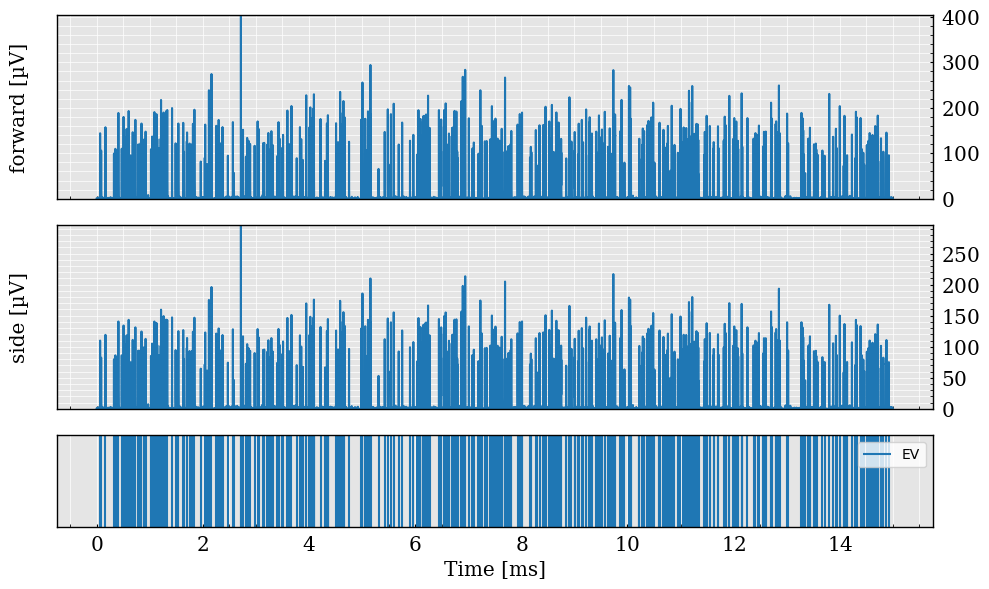

In [ ]:
acquisition.analog.log()
acquisition.analog.plot(filter_population=['EV'])

In [ ]:
triggered_acquisition = acquisition.run_triggering(
    threshold = 20 * units.microvolt,
    trigger_detector_name='forward',
    max_triggers=500,
    pre_buffer=64,
    post_buffer=64
)


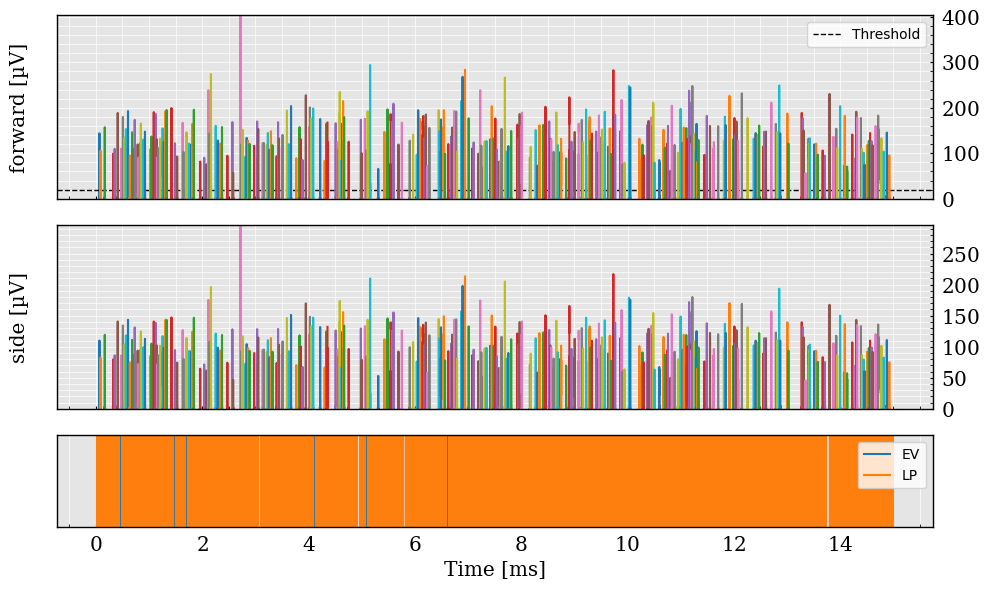

In [ ]:
triggered_acquisition.analog.plot()

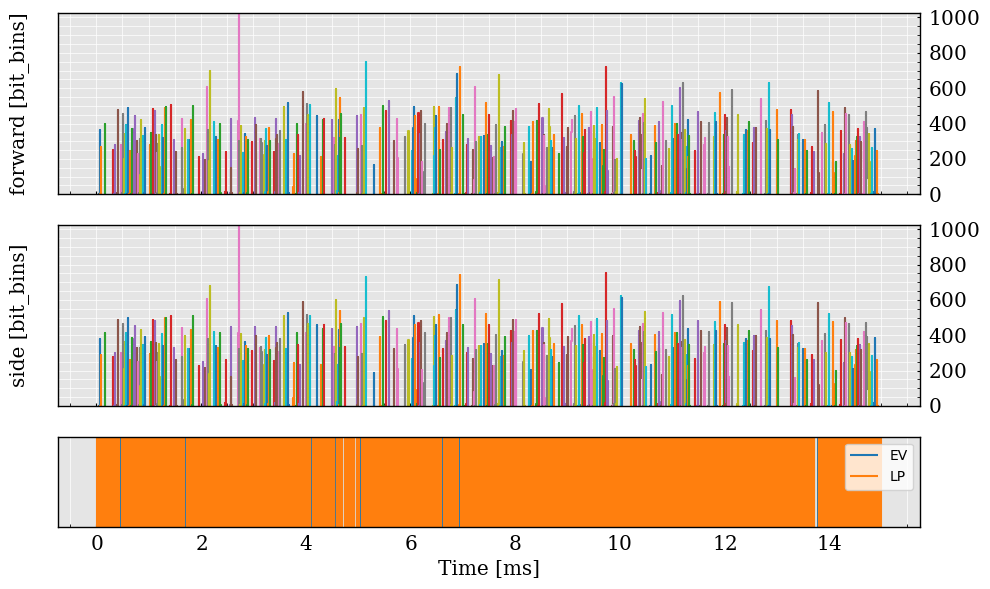

In [ ]:
triggered_acquisition.digital.plot()

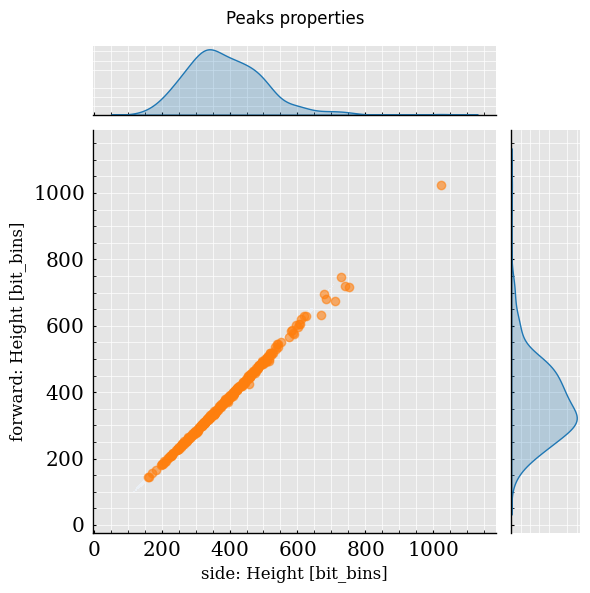

In [ ]:
peak_algorithm = peak_locator.BasicPeakLocator(compute_width=True)

peaks = triggered_acquisition.detect_peaks(peak_algorithm)

peaks.plot(feature='Height', x='side', y='forward')

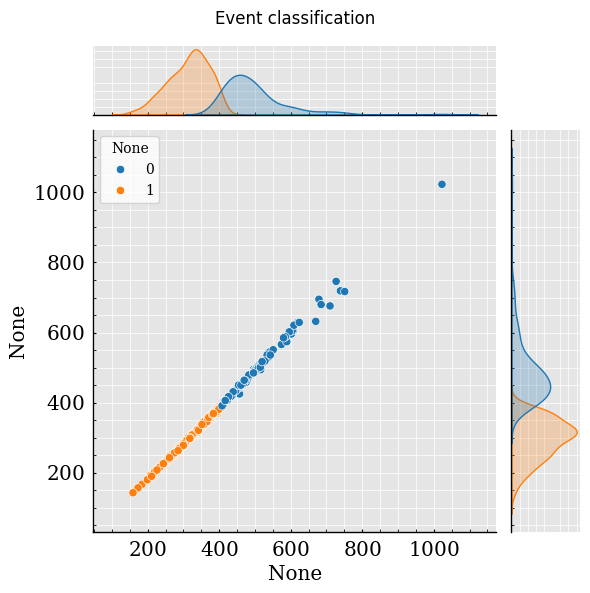

In [ ]:
algorithm = classifier.KmeansClassifier(number_of_cluster=2)

data = algorithm.run(
    dataframe=peaks.unstack('Detector'),
    features=['Height'],
    detectors=['side', 'forward']
)

_ = data.plot(feature='Height', x='side', y='forward')
